<a href="https://colab.research.google.com/github/GIJOE1003/3103ETF/blob/main/Notebook1_Future_Price_Prediction_03th_April.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ETF Future Price Prediction

This notebook forecasts ETF closing prices 7 days ahead using multiple regression models.

In [14]:

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam



## Data Collection

In [15]:
# Data Collection
tickers = ['SPY', 'QQQ', 'GLD','TLT', 'VTI','EEM','XLF','XLV','VEA','VNQ']
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(months=120)

# Download prices
df_raw = yf.download(tickers, start=start_date, end=end_date)

df_open = df_raw['Open'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Open')
df_close = df_raw['Close'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Close')
df_high  = df_raw['High'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='High')
df_low   = df_raw['Low'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Low')
df_volume = df_raw['Volume'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Volume')

# Merge into one DataFrame
df = df_open.merge(df_close, on=['Date', 'Ticker']).merge(df_high, on=['Date', 'Ticker']).merge(df_low, on=['Date', 'Ticker']).merge(df_volume, on=['Date', 'Ticker'])
df = df.round(2)

# Create CSV File
df.to_csv("combined_etf_data.csv", index = False)
print(f"Combined data saved: {df.shape}")
print(df.head())
print(df.tail())

df.isnull().sum()
df.info()


[*********************100%***********************]  10 of 10 completed


Combined data saved: (25160, 7)
        Date Ticker   Open  Close   High    Low    Volume
0 2015-04-13    EEM  34.45  34.18  34.57  34.17  55031100
1 2015-04-14    EEM  34.26  34.34  34.41  34.11  42601100
2 2015-04-15    EEM  34.33  34.58  34.59  34.26  40254700
3 2015-04-16    EEM  34.67  34.85  35.05  34.62  55057700
4 2015-04-17    EEM  34.12  34.24  34.30  34.04  76688000
            Date Ticker    Open   Close    High     Low    Volume
25155 2025-04-04    XLV  141.14  135.28  141.71  135.23  21341100
25156 2025-04-07    XLV  131.71  134.47  137.37  129.66  29940300
25157 2025-04-08    XLV  139.43  132.98  139.44  131.28  20860400
25158 2025-04-09    XLV  130.13  138.76  139.24  129.68  39444700
25159 2025-04-10    XLV  137.70  134.89  137.74  131.33  21956896
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25160 entries, 0 to 25159
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    25160 non-null 

# EDA (Exploratory Data Analysis)

In [16]:
#Summary Stats
summary = df.groupby("Ticker")["Close"].describe()
summary = summary[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
summary=summary.round(2)
display(summary)


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
EEM,2516.0,37.66,5.92,23.18,34.26,37.64,41.23,52.82
GLD,2516.0,154.68,39.54,100.50,120.82,153.82,177.49,292.35
QQQ,2516.0,248.54,123.42,89.91,140.01,215.26,345.74,538.72
SPY,2516.0,324.00,120.94,156.33,221.82,290.03,413.06,611.09
TLT,2516.0,107.06,16.76,77.92,95.29,101.95,119.80,150.87
VEA,2516.0,37.58,7.01,24.41,32.41,36.10,43.46,52.75
VNQ,2516.0,71.61,12.85,47.02,60.92,70.57,80.90,101.98
VTI,2516.0,163.84,59.03,79.19,113.65,147.05,209.09,302.06
XLF,2516.0,27.79,9.00,13.39,21.18,25.10,34.12,52.00


<Figure size 1400x700 with 0 Axes>

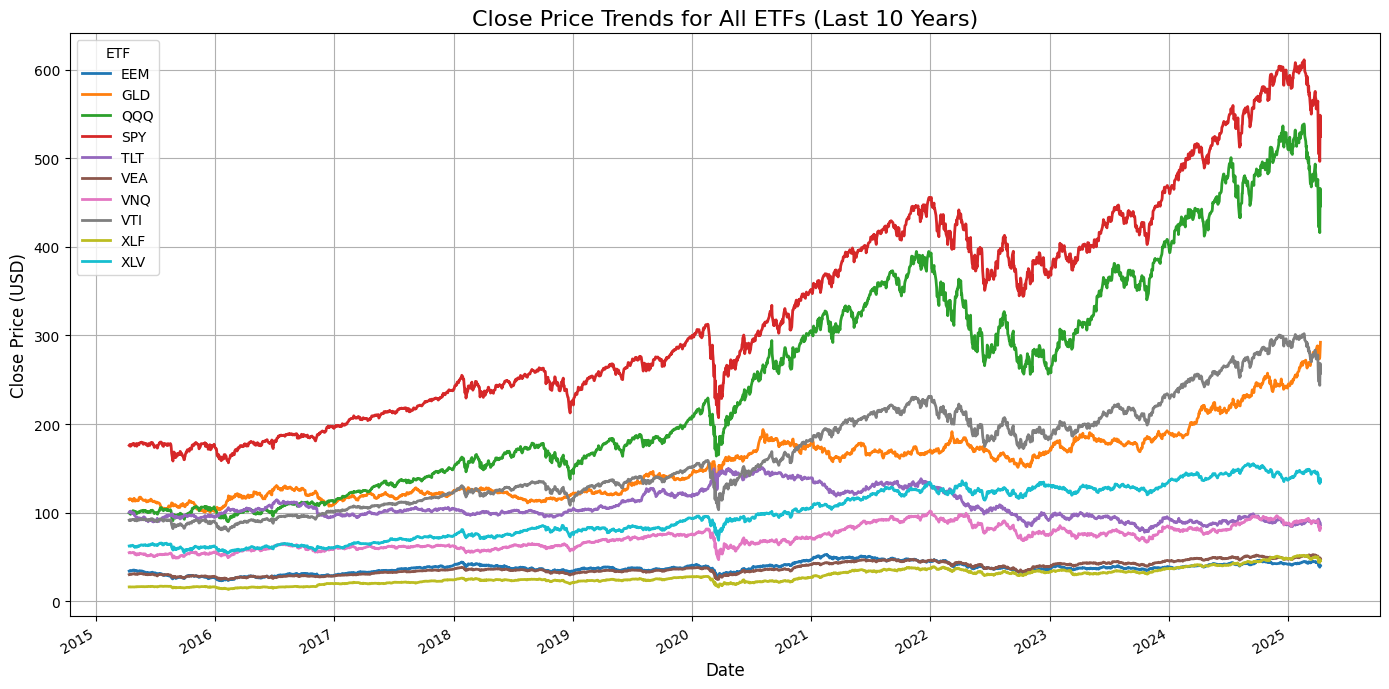

In [17]:
df['Date'] = pd.to_datetime(df['Date'])

last_10yrs = df[df['Date'] >= df['Date'].max() - pd.DateOffset(years=10)]
pivot_df = last_10yrs.pivot(index='Date', columns='Ticker', values='Close')

plt.figure(figsize=(14, 7))
pivot_df.plot(figsize=(14, 7), linewidth=2)

plt.title("Close Price Trends for All ETFs (Last 10 Years)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price (USD)", fontsize=12)
plt.legend(title="ETF", loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## Feature Engineering

In [19]:
df['Return'] = df.groupby('Ticker')['Close'].pct_change().round(4)
df['Return'] = df['Return'].fillna(0.0)
df['Volatility7'] = df.groupby('Ticker')['Return'].rolling(window=20).std().reset_index(level=0, drop=True).round(4)
df['Volatility7'] = df['Volatility7'].fillna(0.0)


df['MA5'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).mean()).round(4)
df['Close_MA5_diff'] = ((df['Close'] - df['MA5']) / df['MA5'] * 100).round(4)

windows = [20, 50, 200]
for w in windows:
    df[f'SMA{w}'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(w).mean()).round(4)
    df[f'EMA{w}'] = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=w, adjust=False).mean()).round(4)


df['PrevClose'] = df.groupby('Ticker')['Close'].shift(1)
df['TR'] = df[['High', 'Low', 'PrevClose']].apply(lambda x: max(x[0]-x[1], abs(x[0]-x[2]), abs(x[1]-x[2])), axis=1).round(4)
df['ATR7'] = df.groupby('Ticker')['TR'].transform(lambda x: x.rolling(7).mean()).round(4)
df['ATR7_pct'] = (df['ATR7'] / df['Close'] * 100).round(4)

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI14'] = df.groupby('Ticker')['Close'].transform(compute_rsi)

ema_12 = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
ema_26 = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())

df['MACD'] = (ema_12 - ema_26).round(4)
df['Signal_Line'] = df.groupby('Ticker')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean()).round(4)

low14 = df.groupby('Ticker')['Low'].transform(lambda x: x.rolling(14).min())
high14 = df.groupby('Ticker')['High'].transform(lambda x: x.rolling(14).max())

df['%K'] = ((df['Close'] - low14) / (high14 - low14) * 100).round(2)
df['%D'] = df.groupby('Ticker')['%K'].transform(lambda x: x.rolling(3).mean())

df['DayOfWeek'] = pd.to_datetime(df['Date']).dt.dayofweek
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['IsMonthEnd'] = pd.to_datetime(df['Date']).dt.is_month_end.astype(int)


df.to_csv("combined_etf_data_features.csv", index = False)
print(f"Combined data saved: {df.shape}")

<ipython-input-19-c7f3bfe94bce>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['TR'] = df[['High', 'Low', 'PrevClose']].apply(lambda x: max(x[0]-x[1], abs(x[0]-x[2]), abs(x[1]-x[2])), axis=1).round(4)


Combined data saved: (25160, 29)


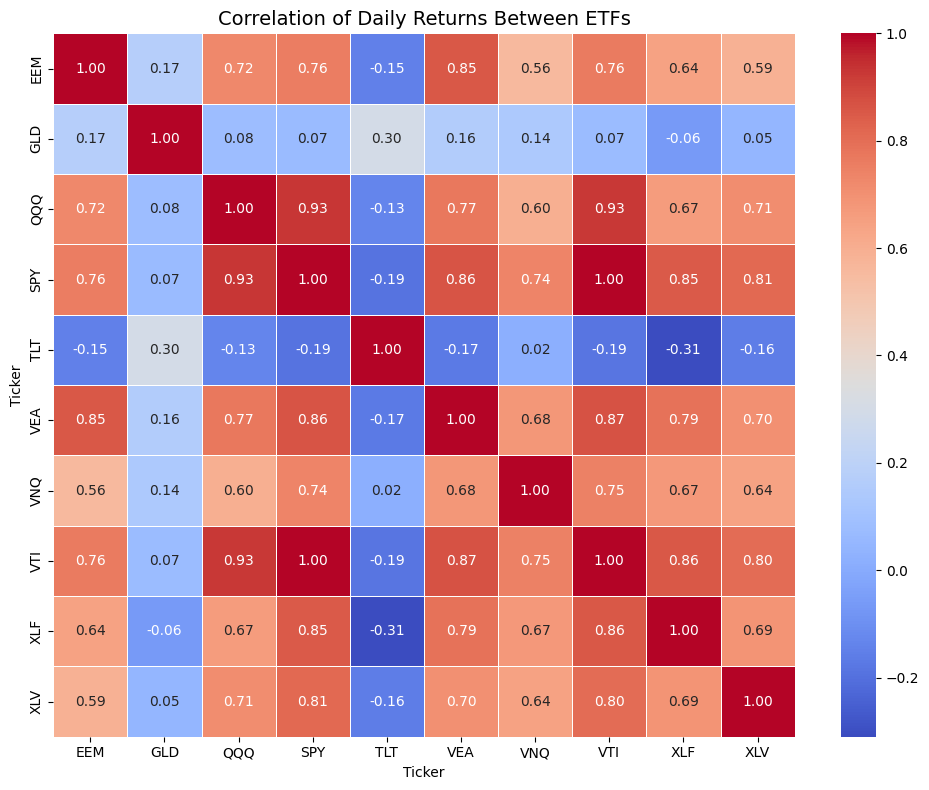

In [21]:
#correlation between tickers

returns_matrix = df.pivot(index='Date', columns='Ticker', values='Return')
returns_matrix = returns_matrix.dropna()
corr_matrix = returns_matrix.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Correlation of Daily Returns Between ETFs", fontsize=14)
plt.tight_layout()
plt.show()



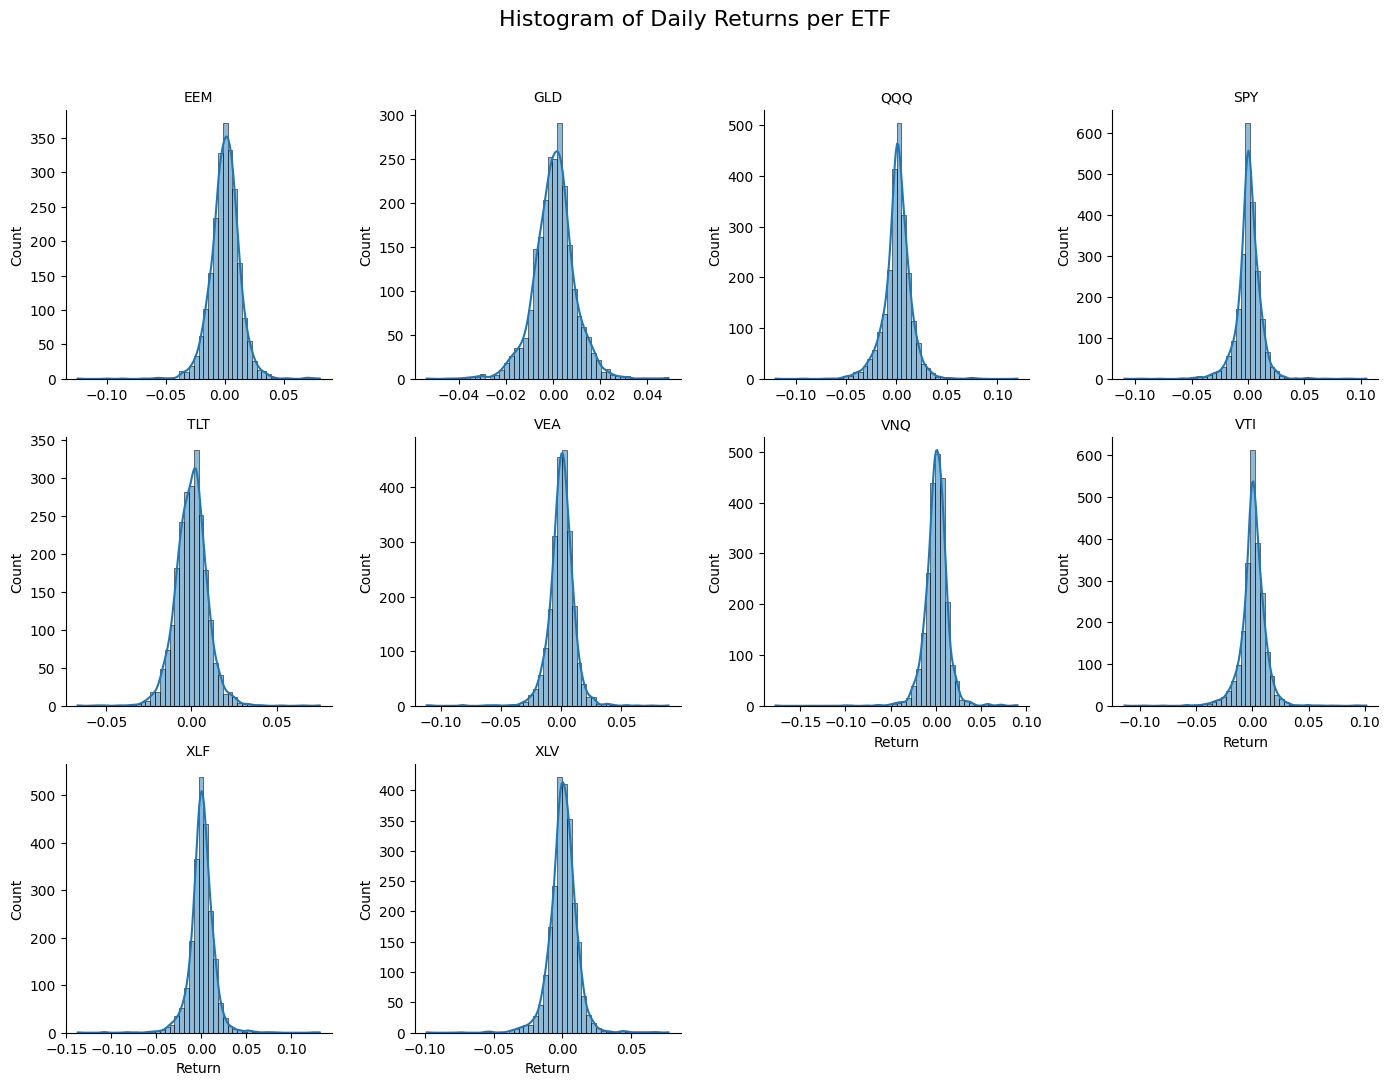

In [22]:
g = sns.FacetGrid(df.dropna(), col="Ticker", col_wrap=4, height=3.5, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x="Return", bins=50, kde=True)
g.set_titles(col_template="{col_name}")
g.fig.suptitle("Histogram of Daily Returns per ETF", y=1.03, fontsize=16)
plt.tight_layout()
plt.show()


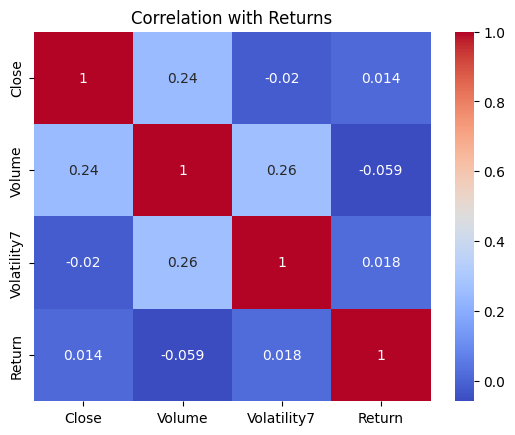

In [23]:
# 14. Feature Correlation with Return
corr_features = df[['Close', 'Volume', 'Volatility7', 'Return']].corr()
sns.heatmap(corr_features, annot=True, cmap='coolwarm')
plt.title("Correlation with Returns")
plt.show()


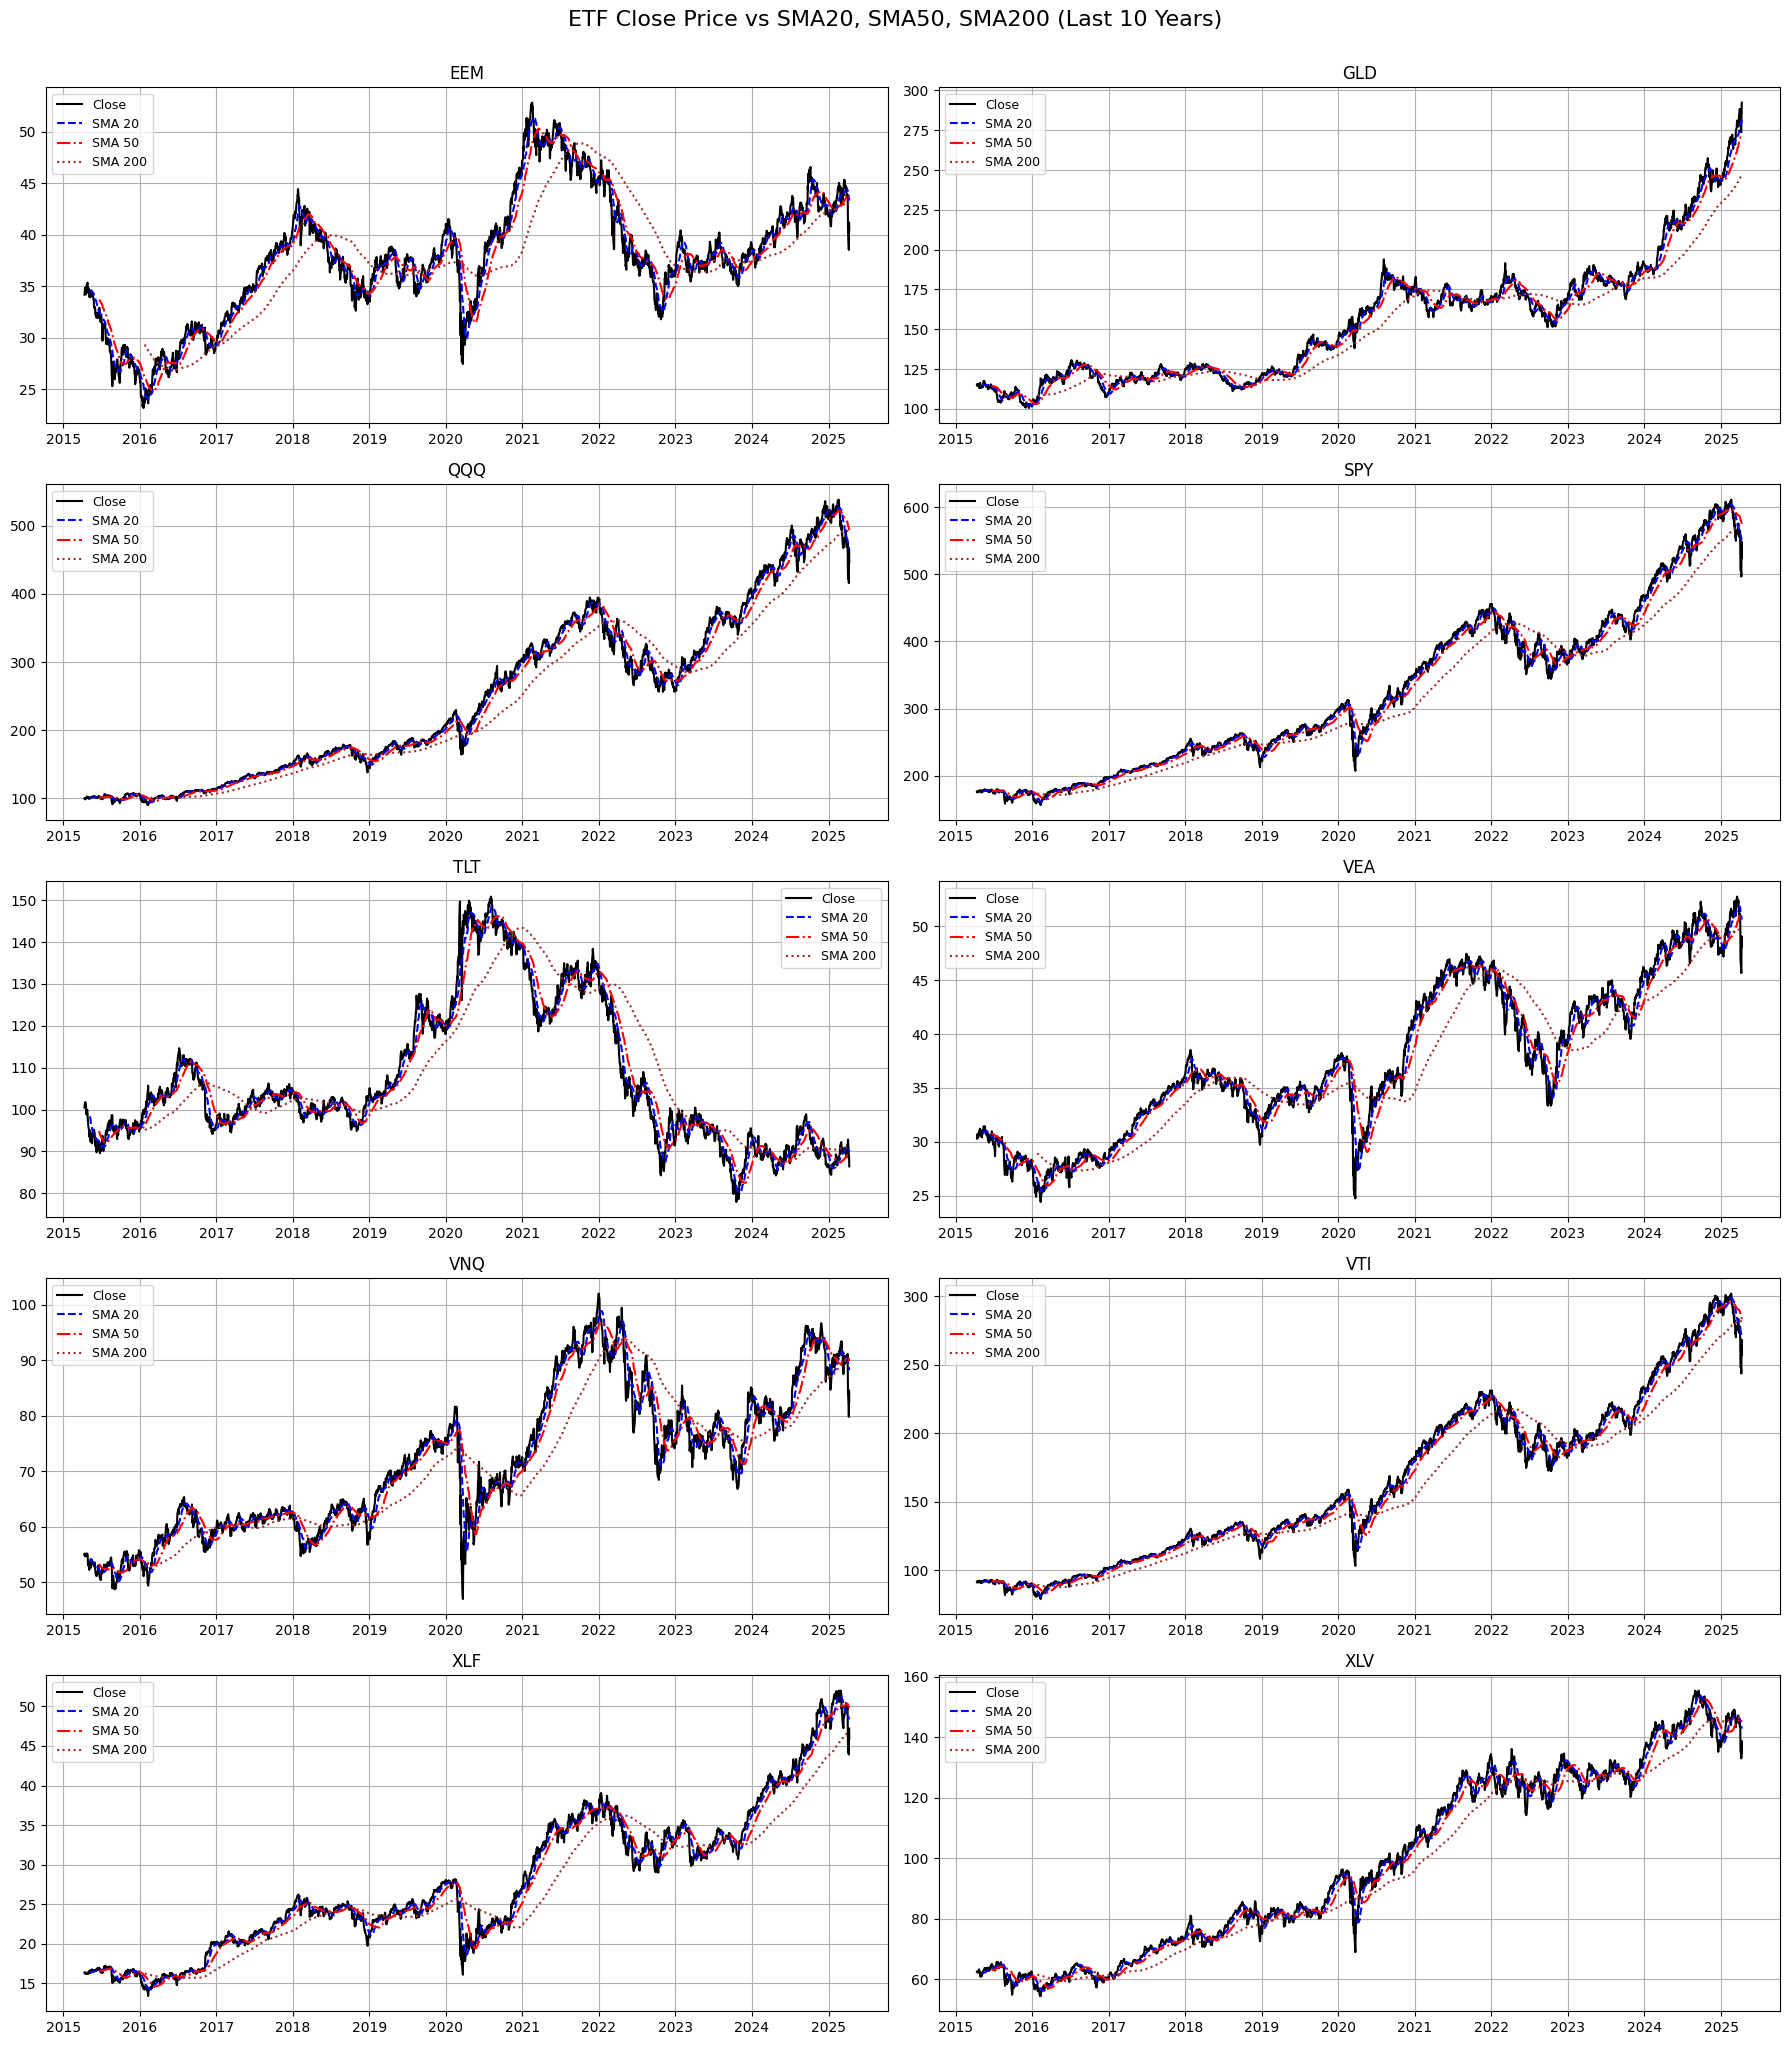

In [25]:
import matplotlib.dates as mdates

df['Date'] = pd.to_datetime(df['Date'])
end_date = df['Date'].max()
start_date = end_date - pd.DateOffset(years=10)


df_10yr = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
etfs = sorted(df_10yr['Ticker'].unique())

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(18, 20), sharex=False)
axs = axs.flatten()

for i, ticker in enumerate(etfs):
    ax = axs[i]
    df_ticker = df_10yr[df_10yr['Ticker'] == ticker].sort_values('Date')

    ax.plot(df_ticker['Date'], df_ticker['Close'], label='Close', color='black')
    ax.plot(df_ticker['Date'], df_ticker['SMA20'], label='SMA 20',color='blue', linestyle='--')
    ax.plot(df_ticker['Date'], df_ticker['SMA50'], label='SMA 50', color = 'red',linestyle='-.')
    ax.plot(df_ticker['Date'], df_ticker['SMA200'], label='SMA 200',color ='brown', linestyle=':')

    ax.set_title(f'{ticker}', fontsize=12)
    ax.grid(True)
    ax.legend(fontsize=9)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
fig.suptitle("ETF Close Price vs SMA20, SMA50, SMA200 (Last 10 Years)", fontsize=16, y=1.02)
plt.show()


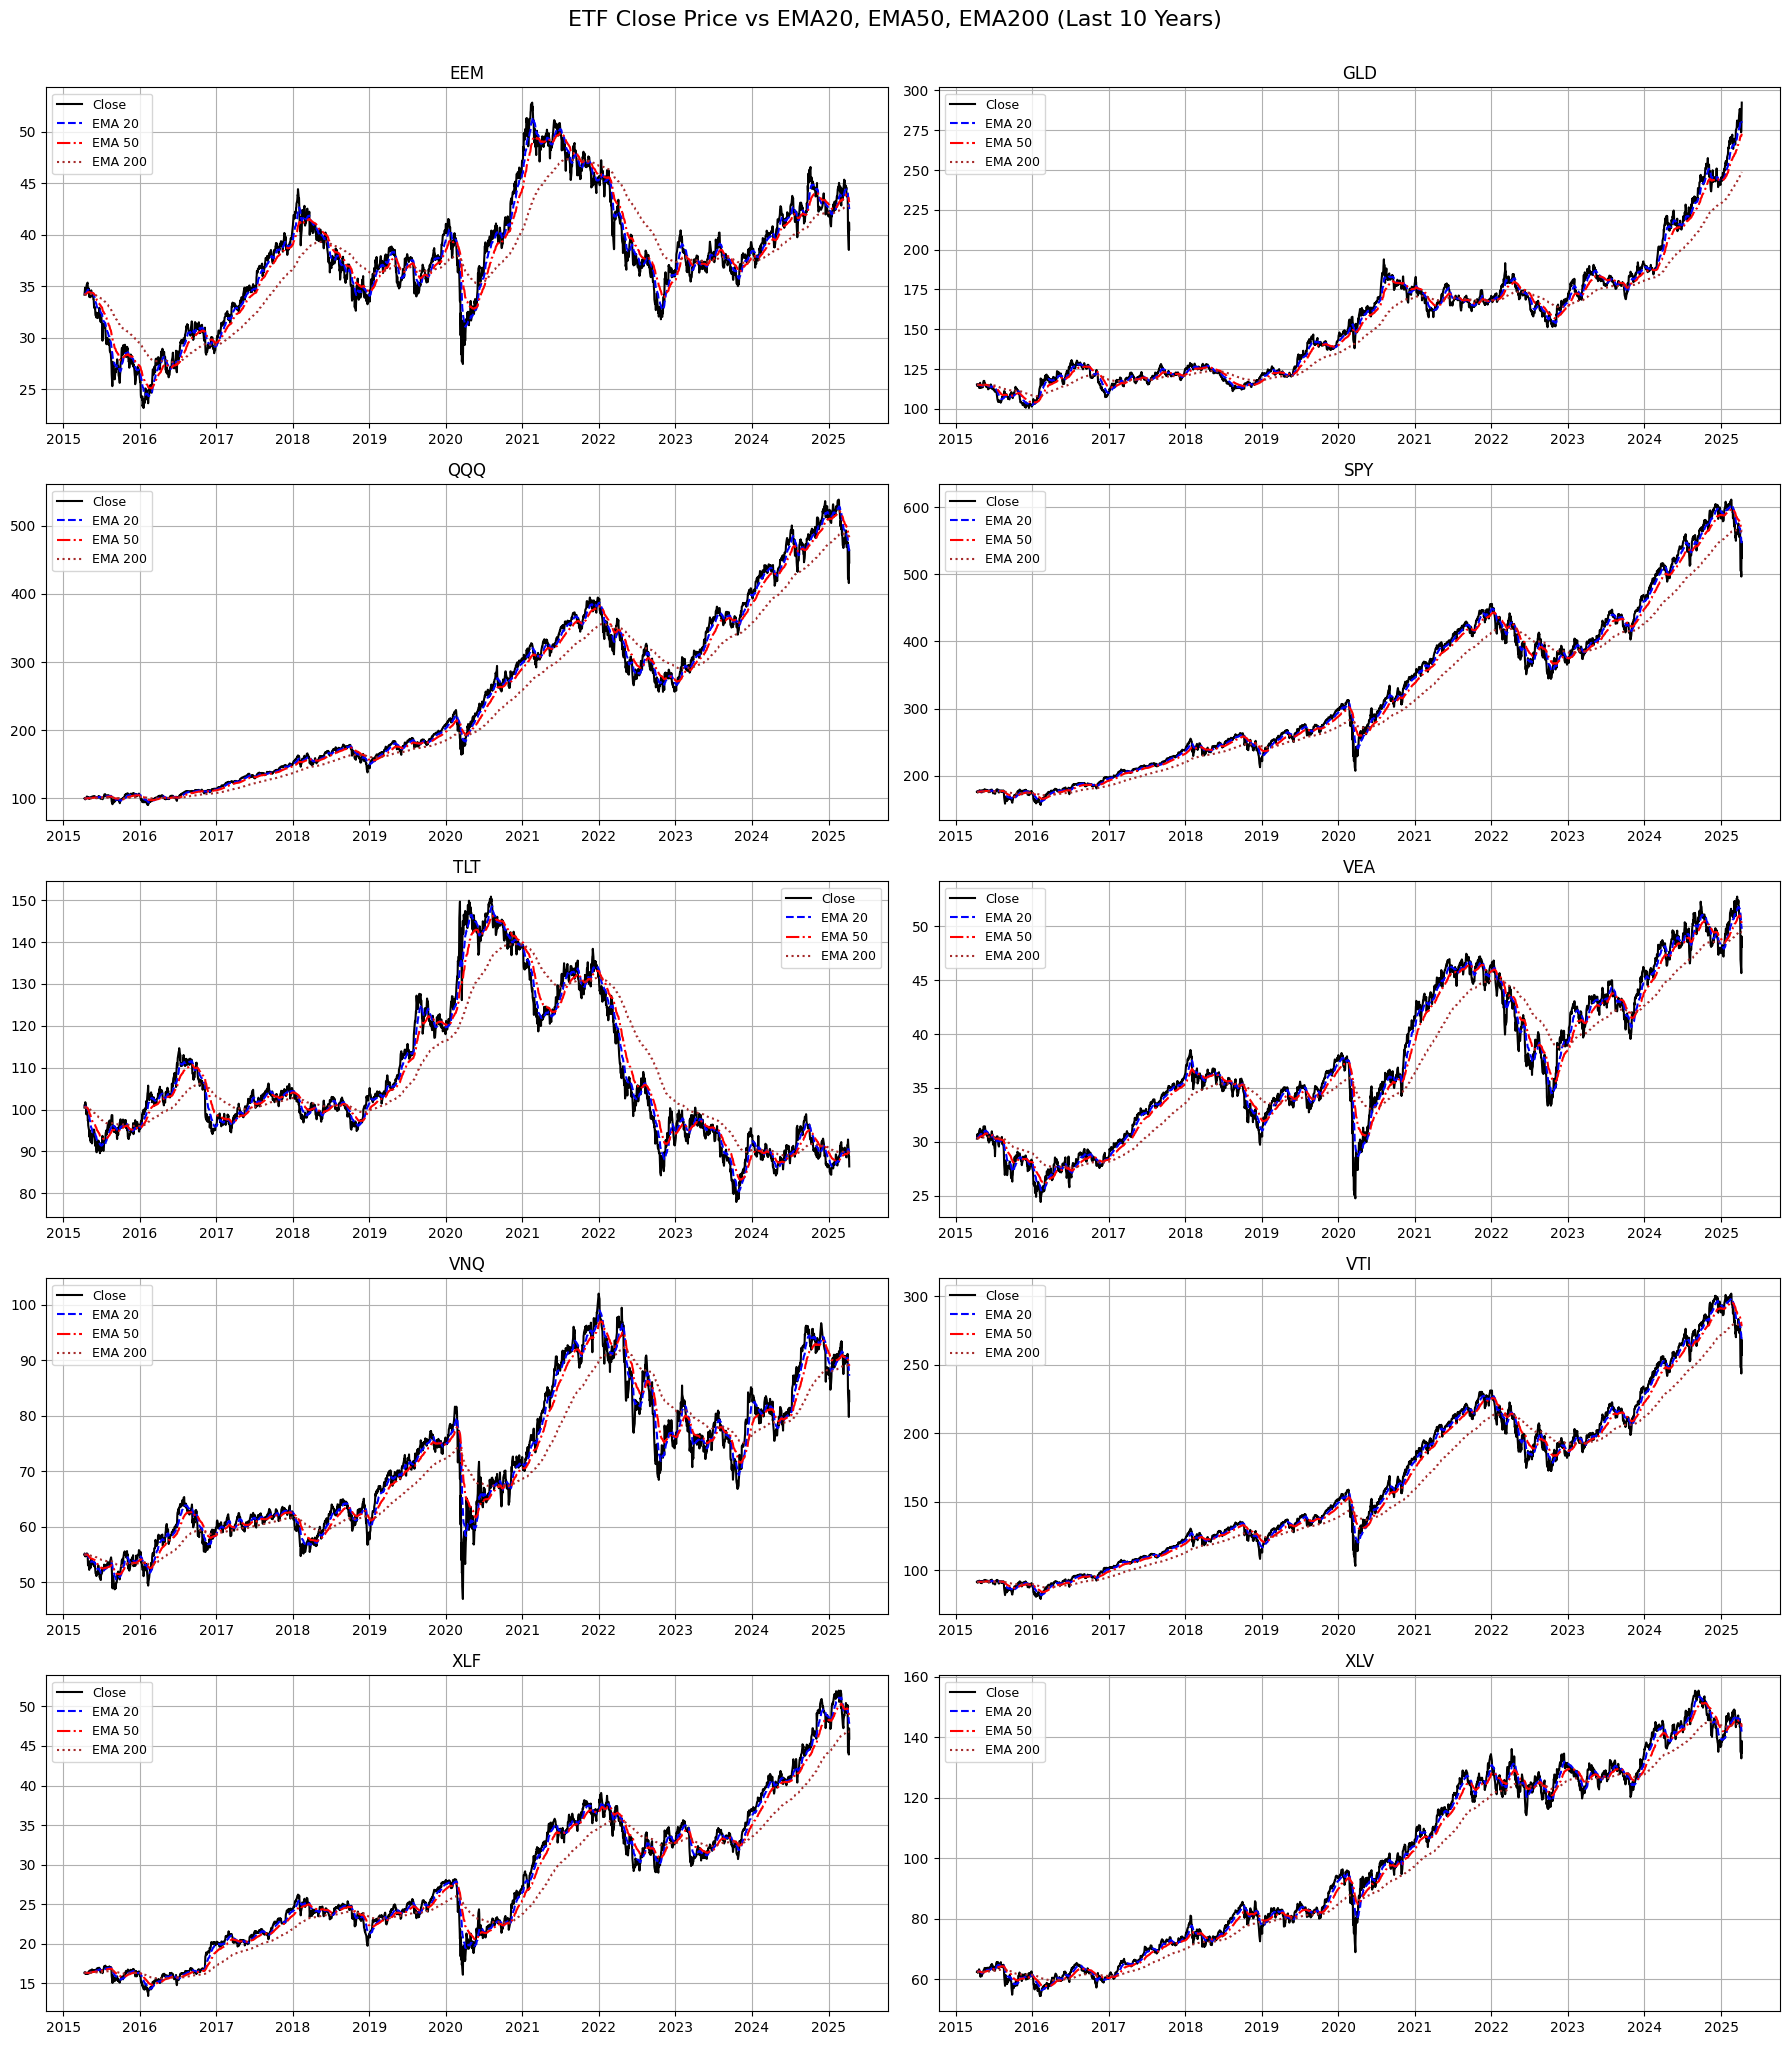

In [26]:
import matplotlib.dates as mdates

df['Date'] = pd.to_datetime(df['Date'])
end_date = df['Date'].max()
start_date = end_date - pd.DateOffset(years=10)


df_10yr = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
etfs = sorted(df_10yr['Ticker'].unique())

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(18, 20), sharex=False)
axs = axs.flatten()

for i, ticker in enumerate(etfs):
    ax = axs[i]
    df_ticker = df_10yr[df_10yr['Ticker'] == ticker].sort_values('Date')

    ax.plot(df_ticker['Date'], df_ticker['Close'], label='Close', color='black')
    ax.plot(df_ticker['Date'], df_ticker['EMA20'], label='EMA 20',color='blue', linestyle='--')
    ax.plot(df_ticker['Date'], df_ticker['EMA50'], label='EMA 50', color = 'red',linestyle='-.')
    ax.plot(df_ticker['Date'], df_ticker['EMA200'], label='EMA 200',color ='brown', linestyle=':')

    ax.set_title(f'{ticker}', fontsize=12)
    ax.grid(True)
    ax.legend(fontsize=9)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
fig.suptitle("ETF Close Price vs EMA20, EMA50, EMA200 (Last 10 Years)", fontsize=16, y=1.02)
plt.show()

In [27]:

# Basic features
df['Return'] = df.groupby('Ticker')['Close'].pct_change()
df['Future_Close'] = df.groupby('Ticker')['Close'].shift(-7)
df.dropna(inplace=True)

features = ['High', 'Low', 'Volume','Return',
    'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20','Volatility7',
    'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7','RSI14','MACD','Signal_Line','%K','%D','DayOfWeek','Month','IsMonthEnd']
X = df[features]
y = df['Future_Close']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


### Linear Regression

In [30]:

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}, R2: {r2_lr:.4f}")

rmse_lr_train = np.sqrt(mean_squared_error(y_train, lr.predict(X_train)))
mae_lr_train = mean_absolute_error(y_train, lr.predict(X_train))
r2_lr_train = r2_score(y_train, lr.predict(X_train))

print(f"Linear Regression - Train RMSE: {rmse_lr_train:.4f}, MAE: {mae_lr_train:.4f}, R2: {r2_lr_train:.4f}")
print (f"Linear Regression - Test RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}, R2: {r2_lr:.4f}")



Linear Regression - RMSE: 1.9942, MAE: 1.3523, R2: 0.9978
Linear Regression - Train RMSE: 5.5013, MAE: 3.1324, R2: 0.9979
Linear Regression - Test RMSE: 1.9942, MAE: 1.3523, R2: 0.9978


### 🔍 Random Forest Regressor

In [ ]:

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}, R2: {r2_rf:.4f}")
rmse_rf_train = np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
print(f"Random Forest - Train RMSE: {rmse_rf_train:.4f}")
print (f"Random Forest - Test RMSE: {rmse_rf:.4f}")


Random Forest - RMSE: 4.0045, MAE: 2.8408, R2: 0.9910
Random Forest - Train RMSE: 1.1171
Random Forest - Test RMSE: 4.0045


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt','log2',None]
}

# Perform grid search
rf_grid = GridSearchCV(RandomForestRegressor(), rf_param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Best model
rf_best = rf_grid.best_estimator_
y_pred_rf_best = rf_best.predict(X_test)

# Evaluation
rmse_rf_best = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
mae_rf_best = mean_absolute_error(y_test, y_pred_rf_best)
r2_rf_best = r2_score(y_test, y_pred_rf_best)
print("Random Forest (Tuned) - RMSE:", rmse_rf_best, "MAE:", mae_rf_best, "R²:", r2_rf_best)
print("Best Params:", rf_grid.best_params_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Random Forest (Tuned) - RMSE: 3.840495975212036 MAE: 2.7174143145080576 R²: 0.9917086170993586
Best Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}


### 🔍 XGBoost Regressor

In [ ]:

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - RMSE: {rmse_xgb:.4f}, MAE: {mae_xgb:.4f}, R2: {r2_xgb:.4f}")


XGBoost - RMSE: 3.7809, MAE: 2.6489, R2: 0.9920


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

xgb_grid = RandomizedSearchCV(XGBRegressor(), xgb_param_grid, cv=3, n_iter=20, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)
xgb_grid.fit(X_train_2d, y_train)

xgb_best = xgb_grid.best_estimator_
y_pred_xgb_best = xgb_best.predict(X_test_2d)

rmse_xgb_best = np.sqrt(mean_squared_error(y_test, y_pred_xgb_best))
mae_xgb_best = mean_absolute_error(y_test, y_pred_xgb_best)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)
print("XGBoost (Tuned) - RMSE:", rmse_xgb_best, "MAE:", mae_xgb_best, "R²:", r2_xgb_best)
print("Best Params:", xgb_grid.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGBoost (Tuned) - RMSE: 3.9545912657034608 MAE: 2.7455820691162374 R²: 0.9912086504430032
Best Params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.9}


### 🔍 LSTM Regressor

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

lookback = 21
forecast_horizon = 7

# ✅ Features (no 'Close' since it's raw and unscaled)
features = ['High', 'Low', 'Return', 'Volume',
    'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20', 'Volatility7',
    'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7',
    'RSI14', 'MACD', 'Signal_Line', '%K', '%D', 'DayOfWeek', 'Month', 'IsMonthEnd']

results = []

for ticker in df['Ticker'].unique():
    print(f"\n📊 LSTM (Return → Price) for {ticker}")
    df_ticker = df[df['Ticker'] == ticker].copy().reset_index(drop=True)

    # Step 1: Backup raw Close
    df_ticker['Raw_Close'] = df_ticker['Close']

    # Step 2: Create future return and store current price
    df_ticker['Future_Return'] = (
        df_ticker['Raw_Close'].shift(-forecast_horizon) - df_ticker['Raw_Close']
    ) / df_ticker['Raw_Close']

    df_ticker['Current_Price'] = df_ticker['Raw_Close']  # to reconstruct price after prediction
    df_ticker.dropna(inplace=True)

    # Step 3: Scale only features
    scaler = StandardScaler()
    df_ticker[features] = scaler.fit_transform(df_ticker[features])

    # Step 4: Create sequences
    X, y, current_prices = [], [], []
    for i in range(lookback, len(df_ticker)):
        X.append(df_ticker[features].iloc[i - lookback:i].values)
        y.append(df_ticker['Future_Return'].iloc[i])
        current_prices.append(df_ticker['Current_Price'].iloc[i])

    X, y, current_prices = np.array(X), np.array(y), np.array(current_prices)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    current_price_test = current_prices[split:]

    # Step 5: Build and train LSTM
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(lookback, len(features))),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=30, batch_size=32,
              validation_split=0.1, callbacks=[early_stop], verbose=0)

    # Step 6: Predict returns
    y_pred_return = model.predict(X_test).flatten()

    # Step 7: Convert return → price
    y_pred_price = current_price_test * (1 + y_pred_return)
    y_test_price = current_price_test * (1 + y_test)

    # Step 8: Evaluate
    rmse = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
    mae = mean_absolute_error(y_test_price, y_pred_price)
    r2 = r2_score(y_test_price, y_pred_price)

    print(f"  ✅ RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")
    print(f"  y_test_price min/max: {y_test_price.min():.2f} / {y_test_price.max():.2f}")
    print(f"  y_pred_price min/max: {y_pred_price.min():.2f} / {y_pred_price.max():.2f}")
    print(f"  Sample y_test_price[:5]: {y_test_price[:5]}")
    print(f"  Sample y_pred_price[:5]: {y_pred_price[:5]}")


    results.append((ticker, rmse, mae, r2))

# Final summary
results_df = pd.DataFrame(results, columns=["Ticker", "RMSE", "MAE", "R2"]).sort_values("RMSE")
display(results_df)



📊 LSTM (Return → Price) for EEM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
  ✅ RMSE: 1.38, MAE: 1.17, R²: 0.7400
  y_test_price min/max: 35.01 / 46.57
  y_pred_price min/max: 36.53 / 47.72
  Sample y_test_price[:5]: [36.66 36.32 36.97 37.61 37.6 ]
  Sample y_pred_price[:5]: [37.44905746 37.50311927 37.72991525 37.0889389  36.89606169]

📊 LSTM (Return → Price) for GLD


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
  ✅ RMSE: 13.81, MAE: 10.41, R²: 0.7950
  y_test_price min/max: 168.83 / 281.11
  y_pred_price min/max: 170.61 / 257.67
  Sample y_test_price[:5]: [182.04 182.32 183.76 181.05 182.14]
  Sample y_pred_price[:5]: [180.10511244 181.94272283 180.67146523 180.58542295 179.05356508]

📊 LSTM (Return → Price) for QQQ


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
  ✅ RMSE: 21.64, MAE: 16.38, R²: 0.8561
  y_test_price min/max: 340.26 / 538.72
  y_pred_price min/max: 328.91 / 502.02
  Sample y_test_price[:5]: [345.54 343.58 347.55 350.16 350.4 ]
  Sample y_pred_price[:5]: [335.0445385  334.05090371 334.95328013 329.62304111 328.91280066]

📊 LSTM (Return → Price) for SPY


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
  ✅ RMSE: 25.37, MAE: 21.34, R²: 0.8355
  y_test_price min/max: 402.63 / 611.09
  y_pred_price min/max: 399.73 / 577.67
  Sample y_test_price[:5]: [408.98 406.71 410.57 416.51 415.71]
  Sample y_pred_price[:5]: [407.51638244 406.29011888 405.669392   401.38112494 399.73323795]

📊 LSTM (Return → Price) for TLT


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
  ✅ RMSE: 3.55, MAE: 2.87, R²: 0.2223
  y_test_price min/max: 77.92 / 98.90
  y_pred_price min/max: 74.74 / 98.06
  Sample y_test_price[:5]: [94.76 95.58 95.96 94.91 94.73]
  Sample y_pred_price[:5]: [94.62432361 94.00274744 93.93587816 93.91654692 92.68467949]

📊 LSTM (Return → Price) for VEA


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
  ✅ RMSE: 1.51, MAE: 1.20, R²: 0.7789
  y_test_price min/max: 39.54 / 52.75
  y_pred_price min/max: 40.45 / 52.52
  Sample y_test_price[:5]: [42.18 41.77 42.41 43.04 42.77]
  Sample y_pred_price[:5]: [42.91104021 43.12650404 43.05967941 42.45476192 41.94062531]

📊 LSTM (Return → Price) for VNQ


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
  ✅ RMSE: 3.66, MAE: 2.89, R²: 0.7538
  y_test_price min/max: 66.82 / 96.66
  y_pred_price min/max: 66.77 / 97.01
  Sample y_test_price[:5]: [73.31 73.68 73.69 75.49 74.96]
  Sample y_pred_price[:5]: [74.59995677 74.20581328 74.28857228 73.5937436  72.046329  ]

📊 LSTM (Return → Price) for VTI


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
  ✅ RMSE: 18.39, MAE: 15.21, R²: 0.6389
  y_test_price min/max: 198.87 / 302.06
  y_pred_price min/max: 197.54 / 278.06
  Sample y_test_price[:5]: [202.55 201.34 203.35 206.71 206.17]
  Sample y_pred_price[:5]: [202.12354338 201.41910313 201.46933627 199.24858214 197.53618056]

📊 LSTM (Return → Price) for XLF


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
  ✅ RMSE: 1.90, MAE: 1.49, R²: 0.9065
  y_test_price min/max: 30.70 / 52.00
  y_pred_price min/max: 30.40 / 49.58
  Sample y_test_price[:5]: [31.06 30.73 31.06 31.73 31.57]
  Sample y_pred_price[:5]: [31.88572019 31.55255042 31.38910563 30.92191463 30.60987302]

📊 LSTM (Return → Price) for XLV


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
  ✅ RMSE: 3.63, MAE: 2.93, R²: 0.8315
  y_test_price min/max: 120.21 / 155.35
  y_pred_price min/max: 123.77 / 154.45
  Sample y_test_price[:5]: [122.71 123.77 124.58 126.18 126.63]
  Sample y_pred_price[:5]: [127.53215475 128.51491611 128.38491325 126.61185594 126.418332  ]


,Ticker,RMSE,MAE,R2
0,EEM,1.383563,1.168682,0.739970
5,VEA,1.509177,1.204991,0.778944
8,XLF,1.901904,1.490580,0.906488
4,TLT,3.547044,2.867534,0.222260
9,XLV,3.631897,2.928683,0.831535
6,VNQ,3.660795,2.890630,0.753840
1,GLD,13.808903,10.412966,0.794955
7,VTI,18.391677,15.207057,0.638888
2,QQQ,21.638587,16.384491,0.856148
3,SPY,25.369095,21.344823,0.835549


In [ ]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

lookback = 21
forecast_horizon = 7

# ✅ Feature set (NO 'Close' since we’re using it as raw unscaled input)
features = ['High', 'Low', 'Return', 'Volume',
    'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20', 'Volatility7',
    'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7',
    'RSI14', 'MACD', 'Signal_Line', '%K', '%D',
    'DayOfWeek', 'Month', 'IsMonthEnd']

results = []

# Define hypermodel
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('lstm_units', 32, 128, step=32),
        return_sequences=False,
        input_shape=(lookback, len(features))
    ))
    model.add(Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='mse'
    )
    return model

for ticker in df['Ticker'].unique():
    print(f"\n🔁 Tuning LSTM (Return → Price) for: {ticker}")
    df_ticker = df[df['Ticker'] == ticker].copy().reset_index(drop=True)

    # Step 1: Backup raw Close and compute return
    df_ticker['Raw_Close'] = df_ticker['Close']
    df_ticker['Future_Return'] = (
        df_ticker['Raw_Close'].shift(-forecast_horizon) - df_ticker['Raw_Close']
    ) / df_ticker['Raw_Close']
    df_ticker['Current_Price'] = df_ticker['Raw_Close']
    df_ticker.dropna(inplace=True)

    # Step 2: Scale features
    scaler = StandardScaler()
    df_ticker[features] = scaler.fit_transform(df_ticker[features])

    # Step 3: Create sequences
    X, y, current_prices = [], [], []
    for i in range(lookback, len(df_ticker)):
        X.append(df_ticker[features].iloc[i - lookback:i].values)
        y.append(df_ticker['Future_Return'].iloc[i])
        current_prices.append(df_ticker['Current_Price'].iloc[i])

    X, y, current_prices = np.array(X), np.array(y), np.array(current_prices)
    split = int(0.8 * len(X))
    X_train, X_val = X[:split], X[split:]
    y_train, y_val = y[:split], y[split:]
    current_price_val = current_prices[split:]

    # Step 4: Tune using Keras Tuner
    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=5,
        executions_per_trial=1,
        overwrite=True,
        directory=f'tuning_dir_{ticker}',
        project_name=f'{ticker}_lstm_return'
    )

    early_stop = EarlyStopping(patience=5, restore_best_weights=True)
    tuner.search(X_train, y_train,
                 validation_data=(X_val, y_val),
                 epochs=25, batch_size=32,
                 callbacks=[early_stop], verbose=0)

    best_model = tuner.get_best_models(1)[0]
    best_hps = tuner.get_best_hyperparameters(1)[0]

    # Step 5: Predict and convert to price
    y_pred_return = best_model.predict(X_val).flatten()
    y_pred_price = current_price_val * (1 + y_pred_return)

    n_preds = len(y_pred_price)

    # Store predictions in a dataframe for export
    pred_df = pd.DataFrame({
    "Date": df_ticker['Date'].iloc[-n_preds:].values,
    "Ticker": ticker*n_preds,
    "Close": current_price_val[-n_preds:],       # Actual current price
    "Predicted_Close": y_pred_price     # LSTM predicted price after forecast_horizon
    })

    # Accumulate predictions across tickers
    if 'all_preds' not in locals():
      all_preds = pred_df
    else:
      all_preds = pd.concat([all_preds, pred_df], ignore_index=True)


    y_val_price = current_price_val * (1 + y_val)

    # Step 6: Evaluate
    rmse = np.sqrt(mean_squared_error(y_val_price, y_pred_price))
    mae = mean_absolute_error(y_val_price, y_pred_price)
    r2 = r2_score(y_val_price, y_pred_price)

    print(f"✅ {ticker} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")
    print(f"Best Hyperparams → units={best_hps.get('lstm_units')}, "
          f"dropout={best_hps.get('dropout_rate'):.2f}, "
          f"lr={best_hps.get('learning_rate'):.5f}")

    # Step 7: Optional plot
   # plt.figure(figsize=(10, 4))
    #plt.plot(y_val_price[:100], label='Actual')
    #plt.plot(y_pred_price[:100], label='Predicted')
    #plt.title(f"{ticker} – Tuned LSTM Price Prediction")
    #plt.legend()
    #plt.grid(True)
    #plt.show()

    results.append((ticker, rmse, mae, r2))

# Summary
results_df_tuned = pd.DataFrame(results, columns=["Ticker", "RMSE", "MAE", "R2"]).sort_values("RMSE")
display(results_df_tuned)


# Save predictions to CSV for signal classification notebook
all_preds.to_csv("predicted_prices.csv", index=False)
print("✅ Saved predicted_prices.csv — ready for signal classification.")




🔁 Tuning LSTM (Return → Price) for: EEM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
✅ EEM - RMSE: 1.25, MAE: 1.04, R²: 0.7878
Best Hyperparams → units=64, dropout=0.30, lr=0.00226

🔁 Tuning LSTM (Return → Price) for: GLD


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
✅ GLD - RMSE: 6.19, MAE: 4.84, R²: 0.9588
Best Hyperparams → units=128, dropout=0.30, lr=0.00913

🔁 Tuning LSTM (Return → Price) for: QQQ


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
✅ QQQ - RMSE: 15.91, MAE: 12.62, R²: 0.9222
Best Hyperparams → units=96, dropout=0.20, lr=0.00791

🔁 Tuning LSTM (Return → Price) for: SPY


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
✅ SPY - RMSE: 15.96, MAE: 12.14, R²: 0.9349
Best Hyperparams → units=128, dropout=0.30, lr=0.00327

🔁 Tuning LSTM (Return → Price) for: TLT


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
✅ TLT - RMSE: 2.70, MAE: 2.21, R²: 0.5504
Best Hyperparams → units=64, dropout=0.40, lr=0.00150

🔁 Tuning LSTM (Return → Price) for: VEA


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
✅ VEA - RMSE: 1.09, MAE: 0.90, R²: 0.8854
Best Hyperparams → units=32, dropout=0.50, lr=0.00523

🔁 Tuning LSTM (Return → Price) for: VNQ


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
✅ VNQ - RMSE: 2.53, MAE: 2.02, R²: 0.8820
Best Hyperparams → units=128, dropout=0.30, lr=0.00504

🔁 Tuning LSTM (Return → Price) for: VTI


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
✅ VTI - RMSE: 6.82, MAE: 5.55, R²: 0.9504
Best Hyperparams → units=128, dropout=0.30, lr=0.00559

🔁 Tuning LSTM (Return → Price) for: XLF


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
✅ XLF - RMSE: 1.45, MAE: 1.16, R²: 0.9459
Best Hyperparams → units=128, dropout=0.20, lr=0.00126

🔁 Tuning LSTM (Return → Price) for: XLV


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
✅ XLV - RMSE: 2.97, MAE: 2.40, R²: 0.8871
Best Hyperparams → units=32, dropout=0.40, lr=0.00967


,Ticker,RMSE,MAE,R2
5,VEA,1.086536,0.899531,0.885420
0,EEM,1.249757,1.037754,0.787834
8,XLF,1.446408,1.155549,0.945916
6,VNQ,2.534311,2.018029,0.882026
4,TLT,2.696987,2.212416,0.550366
9,XLV,2.973540,2.403688,0.887075
1,GLD,6.192775,4.839411,0.958762
7,VTI,6.816641,5.553969,0.950393
2,QQQ,15.911892,12.619439,0.922214
3,SPY,15.963459,12.143107,0.934885


✅ Saved predicted_prices.csv — ready for signal classification.


## 🏁 Final Comparison & Best Model Selection

In [ ]:
# compare all RMSE, MAE and R2

print("Linear Regression - RMSE:", rmse_lr, "MAE:", mae_lr, "R²:", r2_lr)
print("Random Forest - RMSE:", rmse_rf, "MAE:", mae_rf, "R²:", r2_rf)
print("Random Forest (Tuned) - RMSE:", rmse_rf_best, "MAE:", mae_rf_best, "R²:", r2_rf_best)
print("XGBoost - RMSE:", rmse_xgb, "MAE:", mae_xgb, "R²:", r2_xgb)
print("XGBoost (Tuned) - RMSE:", rmse_xgb_best, "MAE:", mae_xgb_best, "R²:", r2_xgb_best)
print("LSTM - RMSE:", results_df['RMSE'].mean(), "MAE:", results_df['MAE'].mean(), "R²:", results_df['R2'].mean())
print("LSTM - RMSE:", results_df['RMSE'].min(), "MAE:", results_df['MAE'].min(), "R²:", results_df['R2'].max())
print("Tuned LSTM - RMSE:", results_df_tuned['RMSE'].mean(), "MAE:", results_df_tuned['MAE'].mean(), "R²:", results_df_tuned['R2'].mean())
print("Tuned LSTM - RMSE:", results_df_tuned['RMSE'].min(), "MAE:", results_df_tuned['MAE'].min(), "R²:", results_df_tuned['R2'].max())



Linear Regression - RMSE: 1.9591212986936664 MAE: 1.333077935831532 R²: 0.9978423798211272
Random Forest - RMSE: 4.043268903549075 MAE: 2.857352770562771 R²: 0.9908099559234791
Random Forest (Tuned) - RMSE: 3.840495975212036 MAE: 2.7174143145080576 R²: 0.9917086170993586
XGBoost - RMSE: 3.780901452013126 MAE: 2.648883919885148 R²: 0.9919639420763398
XGBoost (Tuned) - RMSE: 3.9545912657034608 MAE: 2.7455820691162374 R²: 0.9912086504430032
LSTM - RMSE: 9.484264173615363 MAE: 7.5900437469928494 R²: 0.7358576123430415
LSTM - RMSE: 1.3835632112738891 MAE: 1.1686816412158294 R²: 0.9064879079350414
Tuned LSTM - RMSE: 5.687230619352517 MAE: 4.488289142268231 R²: 0.8704889347613445
Tuned LSTM - RMSE: 1.086536368692393 MAE: 0.8995306275553463 R²: 0.9587615909232162


In [ ]:
# Existing tuned model prediction
best_model = tuner.get_best_models(1)[0]
y_pred = best_model.predict(X_val).flatten()

from pandas.tseries.offsets import BDay
import pandas as pd
import numpy as np
from datetime import datetime

from pandas.tseries.offsets import BDay
import pandas as pd
import numpy as np
from datetime import datetime

forecast_horizon = 7
lookback = 21
today = pd.to_datetime(datetime.today().date())

# Ensure we start from the last valid market date (if today is weekend, step back)
if today.weekday() >= 5:  # Saturday (5) or Sunday (6)
    last_valid_date = today - BDay(1)
else:
    last_valid_date = today

future_predictions = []

for ticker in df['Ticker'].unique():
    print(f"\n📈 Forecasting next {forecast_horizon} business days for: {ticker}")

    df_ticker = df[df['Ticker'] == ticker].copy().reset_index(drop=True)
    df_ticker.dropna(inplace=True)

    # Scale features
    scaled_features = scaler.transform(df_ticker[features])
    last_seq = scaled_features[-lookback:]
    last_close = df_ticker['Close'].iloc[-1]

    # Generate next 7 **business days** starting after the last valid date
    future_dates = pd.date_range(start=last_valid_date + BDay(1), periods=forecast_horizon, freq=BDay())

    seq = last_seq.copy()
    predicted_prices = []
    predicted_returns = []

    for step in range(forecast_horizon):
        input_seq = np.expand_dims(seq, axis=0)
        pred_return = best_model.predict(input_seq, verbose=0)[0][0]
        predicted_returns.append(pred_return)

        next_price = last_close * (1 + pred_return)
        predicted_prices.append(next_price)

        # Use previous features (optional: generate updated features here)
        new_row = seq[-1].copy()
        seq = np.vstack([seq[1:], new_row])
        last_close = next_price

    # Store predictions
    pred_df = pd.DataFrame({
        "Ticker": [ticker] * forecast_horizon,
        "Date": future_dates,
        "Predicted_Close": predicted_prices,
        "Predicted_Return": predicted_returns,
    })

    future_predictions.append(pred_df)

# Combine and save
final_future_df = pd.concat(future_predictions, ignore_index=True)
final_future_df.to_csv("future_7day_prices.csv", index=False)

print("✅ Saved future_7day_prices.csv with correct market dates (no weekends).")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

📈 Forecasting next 7 business days for: EEM

📈 Forecasting next 7 business days for: GLD

📈 Forecasting next 7 business days for: QQQ

📈 Forecasting next 7 business days for: SPY

📈 Forecasting next 7 business days for: TLT

📈 Forecasting next 7 business days for: VEA

📈 Forecasting next 7 business days for: VNQ

📈 Forecasting next 7 business days for: VTI

📈 Forecasting next 7 business days for: XLF

📈 Forecasting next 7 business days for: XLV
✅ Saved future_7day_prices.csv with correct market dates (no weekends).
